# RFM Segmentation

In [22]:
import sys
sys.path.append('D:/source/repos')
from utilities.std_imports import *
import datetime as dt
from IPython.display import Image

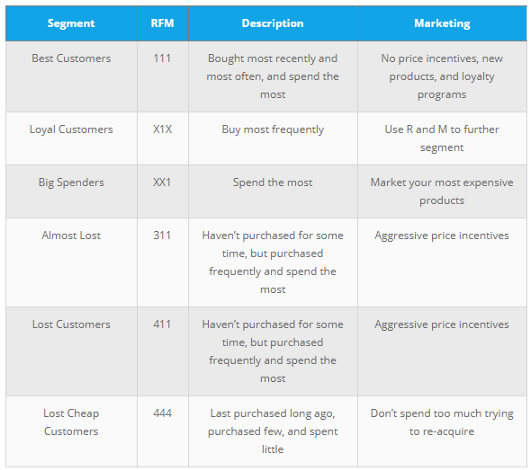

In [24]:
Image(filename='supply_chain/scm/rfm.png') 

### Load data

In [3]:
df = pd.read_excel("D:/data/csv/supply_chain/online_retail.xlsx")
df1 = df
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
customer_country=df1[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [6]:
df1 = df1.loc[df1['Country'] == 'United Kingdom']
df1 = df1[pd.notnull(df1['CustomerID'])]

In [7]:
df1 = df1[(df1['Quantity']>0)]
df1.shape
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354345 non-null  object        
 1   StockCode    354345 non-null  object        
 2   Description  354345 non-null  object        
 3   Quantity     354345 non-null  int64         
 4   InvoiceDate  354345 non-null  datetime64[ns]
 5   UnitPrice    354345 non-null  float64       
 6   CustomerID   354345 non-null  float64       
 7   Country      354345 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


In [9]:
df1['TotalPrice'] = df1['Quantity'] * df1['UnitPrice']

In [10]:
now = dt.datetime(2011,12,10)
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])

### Create RFM table

In [12]:
rfm = df1.groupby('CustomerID').agg({'InvoiceDate': lambda x: (now - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})
rfm['InvoiceDate'] = rfm['InvoiceDate'].astype(int)
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Mon_value'}, inplace=True)
rfm.head()

,Recency,Frequency,Mon_value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


### Segmented RFM

In [15]:
qs = rfm.quantile(q=[0.25,0.5,0.75])
qs = qs.to_dict()

In [16]:
segm_rfm = rfm

In [17]:
def RScore(x,p,d):
    if x <= d[p][0.25]: return 1
    elif x <= d[p][0.50]: return 2
    elif x <= d[p][0.75]: return 3
    else: return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]: return 4
    elif x <= d[p][0.50]: return 3
    elif x <= d[p][0.75]: return 2
    else: return 1

In [20]:
segm_rfm['r_quartile'] = segm_rfm['Recency'].apply(RScore, args=('Recency',qs,))
segm_rfm['f_quartile'] = segm_rfm['Frequency'].apply(FMScore, args=('Frequency',qs,))
segm_rfm['m_quartile'] = segm_rfm['Mon_value'].apply(FMScore, args=('Mon_value',qs,))
segm_rfm.head()

,Recency,Frequency,Mon_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [21]:
segm_rfm['RFMScore'] = segm_rfm.r_quartile.map(str) + segm_rfm.f_quartile.map(str) + segm_rfm.m_quartile.map(str)
segm_rfm.head()

,Recency,Frequency,Mon_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12747.0,2,103,4196.01,1,1,1,111
12748.0,0,4596,33719.73,1,1,1,111
12749.0,3,199,4090.88,1,1,1,111
12820.0,3,59,942.34,1,2,2,122


### Credits & Links

https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6